In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from importlib.machinery import SourceFileLoader
import torch

In [2]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/BBH_and_Machine_Learning"
PROJECT_PATH = join(ROOT, PROJ)

Mounted at /content/drive


In [3]:
DEVICE = 'cuda'

# Generate datasets

In [ ]:
rd = SourceFileLoader('rd',join(PROJECT_PATH,'Modules/Ringdown2.py')).load_module()

In [ ]:
from rd import qnm_Kerr

### Train dataset

In [ ]:
## times
sampling_rate = 4096
dt = 1/sampling_rate
bins = 256
times = np.linspace(0,bins*dt,bins)

## parameters
masses = [25,100]
spins = [0,0.9]
qs = [1,8]
modes = [(2,2),(3,3),(2,1)]
phases = [0,2*np.pi]
iota = np.pi/3

## load psd for SNR
noise_file = PROJECT_PATH+'/Data/ETD_sensitivity.txt'
df = pd.read_csv(noise_file,sep='   ',engine='python',names=['f','s1','s2','stot'])
x, y = df['f'], df['stot']**2
noise_curve = interp1d(x,y)

## generate data and target
n_samples = 10**5
data = []
target = []
snrs = []
for i in range(n_samples):
  mass = np.random.uniform(*masses)
  q = np.random.uniform(*qs)
  spin = np.random.uniform(*spins)
  distance = 1000
  phase = np.random.uniform(*phases)
  hp,_ = rd.RDwaveform(mass,spin,q,modes,times,iota,phase,distance,method='numerical')
  data.append(hp)
  target.append([mass,spin,q,distance])
  ## compute SNR
  snrs.append(rd.SNR(mass,spin,q,iota,distance,modes,noise_curve,method='numerical')[0])

data = np.array(data)
target = np.array(target)
snr = np.array(snrs)

## save
filename = PROJECT_PATH+'/Data/qnm_3m_numerical.hdf5'
mode = 'a'
group = 'train'
target_labels = ['mass','spin','mratio','dL']
with h5py.File(filename,mode) as f:
    X = f.create_dataset(group+'/data',dtype=np.float,data=data)
    y = f.create_dataset(group+'/target',dtype=np.float,data=target)
    y.attrs['labels'] = target_labels
    z = f.create_dataset(group+'/snr',dtype=np.float,data=snrs)

### Test dataset

In [ ]:
## times
sampling_rate = 4096
dt = 1/sampling_rate
bins = 256
times = np.linspace(0,bins*dt,bins)

## parameters
masses = [25,100]
spins = [0,0.9]
qs = [1,8]
modes = [(2,2),(3,3),(2,1)]
phases = [0,2*np.pi]
iota = np.pi/3

## load psd for SNR
noise_file = PROJECT_PATH+'/Data/ETD_sensitivity.txt'
df = pd.read_csv(noise_file,sep='   ',engine='python',names=['f','s1','s2','stot'])
x, y = df['f'], df['stot']**2
noise_curve = interp1d(x,y)

## generate data and target
n_samples = 10**3
data = []
target = []
snrs = []
for i in range(n_samples):
  mass = np.random.uniform(*masses)
  q = np.random.uniform(*qs)
  spin = np.random.uniform(*spins)
  distance = 1000
  phase = np.random.uniform(*phases)
  hp,_ = rd.RDwaveform(mass,spin,q,modes,times,iota,phase,distance,method='numerical')
  data.append(hp)
  target.append([mass,spin,q,distance])
  ## compute SNR
  snrs.append(rd.SNR(mass,spin,q,iota,distance,modes,noise_curve,method='numerical')[0])

data = np.array(data)
target = np.array(target)
snr = np.array(snrs)

## save
filename = PROJECT_PATH+'/Data/qnm_3m_numerical.hdf5'
mode = 'a'
group = 'test'
target_labels = ['mass','spin','mratio','dL']
with h5py.File(filename,mode) as f:
    X = f.create_dataset(group+'/data',dtype=np.float,data=data)
    y = f.create_dataset(group+'/target',dtype=np.float,data=target)
    y.attrs['labels'] = target_labels
    z = f.create_dataset(group+'/snr',dtype=np.float,data=snrs)

### Test dataset 2

In [ ]:
## times
sampling_rate = 4096
dt = 1/sampling_rate
bins = 256
times = np.linspace(0,bins*dt,bins)

## parameters
masses = [25,100]
qs = [1,8]
modes = [(2,2),(3,3),(2,1)]
phases = [0,2*np.pi]
iota = np.pi/3

## load psd for SNR
noise_file = PROJECT_PATH+'/Data/ETD_sensitivity.txt'
df = pd.read_csv(noise_file,sep='   ',engine='python',names=['f','s1','s2','stot'])
x, y = df['f'], df['stot']**2
noise_curve = interp1d(x,y)

## generate data and target
n_samples = 10**3
data = []
target = []
snrs = []
for i in range(n_samples):
  mass = np.random.uniform(*masses)
  q = np.random.uniform(*qs)
  spin = rd.spin_fit(q)
  distance = 1000
  phase = np.random.uniform(*phases)
  hp,_ = rd.RDwaveform(mass,spin,q,modes,times,iota,phase,distance,method='numerical')
  data.append(hp)
  target.append([mass,spin,q,distance])
  ## compute SNR
  snrs.append(rd.SNR(mass,spin,q,iota,distance,modes,noise_curve,method='numerical')[0])

data = np.array(data)
target = np.array(target)
snr = np.array(snrs)

## save
filename = PROJECT_PATH+'/Data/qnm_3m_numerical.hdf5'
mode = 'a'
group = 'test2'
target_labels = ['mass','spin','mratio','dL']
with h5py.File(filename,mode) as f:
    X = f.create_dataset(group+'/data',dtype=np.float,data=data)
    y = f.create_dataset(group+'/target',dtype=np.float,data=target)
    y.attrs['labels'] = target_labels
    z = f.create_dataset(group+'/snr',dtype=np.float,data=snrs)

# Explore dataset

In [ ]:
mymodule = SourceFileLoader('mymodule',join(PROJECT_PATH,'Modules/qnm_cvae.py')).load_module()
from mymodule import GWDataset

In [ ]:
## open
filename = PROJECT_PATH+'/Data/qnm_3m_numerical.hdf5'
filename2 = PROJECT_PATH+'/Data/Noises.hdf5'
mode = 'r'
group = 'test'

nbins = 128

with h5py.File(filename,mode) as f:
  X = f[group+'/data'][()][:,:nbins]
  y = f[group+'/target'][()]
  z = f[group+'/snr'][()]
  labels = f[group+'/target'].attrs['labels']
dataset = GWDataset(X,y,z)

with h5py.File(filename2,mode) as f:
  noise = f['ET/noise'][()][:len(dataset),:nbins]

In [ ]:
dataset.add_noise(noise,SNR=60);

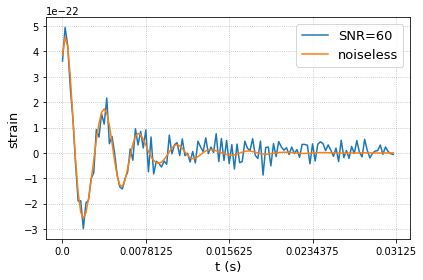

In [ ]:
idx = np.argsort(y[:,0])
plt.plot(dataset.x[idx[500]],label='SNR=%d'%60,color='C0')
A = 60/dataset.snr[idx[500]]
plt.plot(A*dataset.x0[idx[500]],label='noiseless',color='C1')
plt.legend(fontsize=13)
plt.ylabel('strain',fontsize=13)
plt.xlabel('t (s)',fontsize=13)
plt.xticks(np.linspace(0,128,5),np.linspace(0,128/4096,5))
plt.tight_layout()
plt.grid(linestyle=':',alpha=0.9)
#plt.savefig(PROJECT_PATH+'/plots/signal.pdf',bbox_inches='tight')

# Train

In [ ]:
%cd drive/My\ Drive/BBH_and_Machine_Learning/

/content/drive/My Drive/BBH_and_Machine_Learning


In [ ]:
%%time
!python3 Modules/train_script.py '/content/drive/My Drive/BBH_and_Machine_Learning' 'cuda' 'qnm_3m_numerical.hdf5' 100000 3 'foo.pkl' 'None' 40 80

# Test

In [4]:
mymodule = SourceFileLoader('mymodule',join(PROJECT_PATH,'Modules/qnm_cvae.py')).load_module()
from mymodule import GWDataset, Regressor_Bayes, CVAE, PP_plot_tail, PP_plot_median
mymodule.DEVICE = DEVICE

First of all, we load the model and the corresponding network

In [5]:
## load the model
modelfile = PROJECT_PATH+'/cvae_models/foo_128_10.pkl'
checkpoint = torch.load(modelfile)
net = CVAE(**checkpoint['params']).to(DEVICE)
model = Regressor_Bayes(net)
model.load(modelfile,map_location=DEVICE)

Then, I count the trainable parameters of the network

In [6]:
total_params = sum(p.numel() for p in net.parameters()\
                   if p.requires_grad)
print('trainable params: %d'%total_params)

trainable params: 57366


Then, we explore some stats of the training, such as the training time and the evolution of the losses across the training epochs

In [7]:
print('Training time: %.0f mins'%(checkpoint['train_time']/60))

Training time: 60 mins


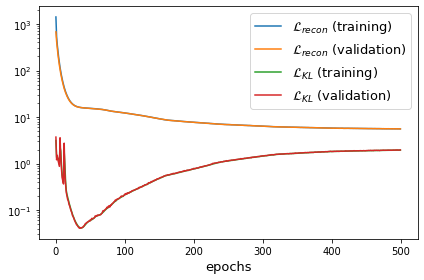

In [8]:
## explore the evolution of losses
losses = checkpoint['losses']
tL = losses['train_L']
tKL = losses['train_KL']
tT = losses['train_tot']
vL = losses['valid_L']
vKL = losses['valid_KL']
vT = losses['valid_tot']
epochs = list(range(len(tL)))
plt.plot(epochs,tL,label='$\mathcal{L}_{recon}$ (training)')
plt.plot(epochs,vL,label='$\mathcal{L}_{recon}$ (validation)')
plt.plot(epochs,tKL,label='$\mathcal{L}_{KL}$ (training)')
plt.plot(epochs,vKL,label='$\mathcal{L}_{KL}$ (validation)')
plt.xlabel('epochs',fontsize=13)
plt.legend(loc='upper right',fontsize=13)
plt.yscale('log')
plt.tight_layout()
#plt.savefig(PROJECT_PATH+'/plots/losses.pdf',bbox_inches='tight')

At this point, we load the test dataset and the noises, and in the subsequent cell we can decide to modify the signals according to a given array of SNRs

In [9]:
DATA_FILE = join(PROJECT_PATH,'Data/qnm_3m_numerical.hdf5')
NOISE_FILE = PROJECT_PATH+'/Data/Noises.hdf5'

## prepare data
ny = 3
group='test'
NBINS = 128
with h5py.File(DATA_FILE,'r') as f:
  X_test = f[group+'/data'][()][:,:NBINS]
  y_test = f[group+'/target'][()][:,:ny]
  z_test = f[group+'/snr'][()]
  labels = f[group+'/target'].attrs['labels'][:ny]
testset = GWDataset(X_test,y_test,z_test)

with h5py.File(NOISE_FILE,'r') as f:
  noise = f['ET/noise'][()][-len(testset):,:NBINS]

In [ ]:
## sample from the testset
SNR = np.random.uniform(40,80,len(testset))
#SNR = 60
testset.reset().add_noise(noise,SNR);

Finally, we estimate posterior samples from the test dataset, and we print the Kolmogorov-Smirnov statistics for each observable

In [ ]:
%%time
n_samples = int(1e4)
samples = model.sample(testset.x,n_samples)
testset.reset();
print(model.score(samples,testset.y))

[0.06457576 0.02628283 0.03575758]
CPU times: user 38.4 s, sys: 792 ms, total: 39.2 s
Wall time: 39.2 s


Here below, we show a P-P plot of the resulting posterior samples. Here the `PP_plot_median` function assumes that the confidence interval is calculated around the mean. Alternatively, one can use the `PP_plot_tail` function to count the confidence interval starting from the leftmost tail of the posterior distributions.

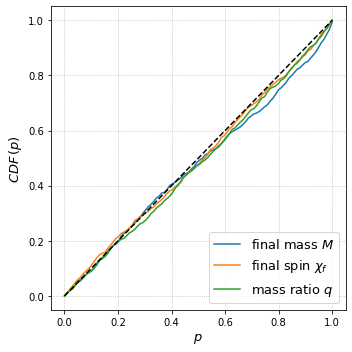

In [ ]:
## PP plot_mean
names = ['final mass $M$','final spin $\chi_f$','mass ratio $q$']
CL = np.linspace(0,1,100)
scores, KS = PP_plot_median(samples,testset.y,CL=CL);
plt.figure(figsize=(5,5))
for i in range(len(scores)):
#  plt.plot(CL,scores[i],label=names[i]+' (%.2f)'%KS[i])
  plt.plot(CL,scores[i],label=names[i])
plt.plot(CL,CL,'--',color='black')
plt.legend(loc='lower right',fontsize=13)
plt.xlabel('$p$',fontsize=13)
plt.ylabel('$CDF\,(p)$',fontsize=13)
plt.tight_layout()
plt.grid(linestyle=':',alpha=0.9)
#plt.savefig(PROJECT_PATH+'/plots/pp_test_128.pdf',bbox_inches='tight')

Let us investigate some other statistical features of the posterior samples. In particular, we look at the relative bias and at the standard deviation $\sigma$ (more specifically, we look at $\sigma\rho$ where $\rho$ is the SNR, because it is a quantity which can be confronted directly with a Fisher matrix estimate).

In [ ]:
mu = np.median(samples,axis=-1)
bias = np.abs(mu/testset.y-1)
names = ['mass','spin','mass ratio']
for i in range(len(names)):
  print('The average relative bias over the %s is %.3f'%(names[i],np.mean(bias,axis=0)[i]))

The average relative bias over the mass is 0.020
The average relative bias over the spin is 0.305
The average relative bias over the mass ratio is 0.122


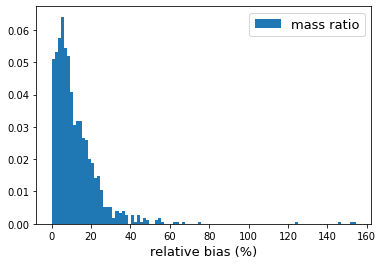

In [ ]:
i = 2
plt.hist(bias[:,i]*100,bins=100,density=True,label=names[i])
plt.legend(fontsize=13)
plt.xlabel('relative bias (%)',fontsize=13)
plt.show()

In [ ]:
p = 0.68
L = samples.shape[-1]
a, b = int(0.5*L*(1-p)), int(0.5*L*(1+p))
posteriors = np.sort(samples,axis=-1)
mm, mp = posteriors[:,:,a], posteriors[:,:,b]
sigma = 0.5*(mp-mm)
sigmarho = sigma*(SNR.reshape(-1,1))

In [ ]:
names = ['mass','spin','mass ratio']
for i in range(len(names)):
  print('The average sigma*SNR over the %s is %.2f'%(names[i],np.mean(sigmarho[:,i])))

The average sigma*SNR over the mass is 90.21
The average sigma*SNR over the spin is 2.72
The average sigma*SNR over the mass ratio is 35.31


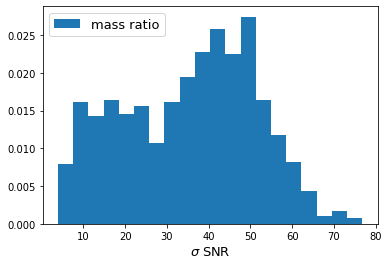

In [ ]:
i = 2
plt.hist(sigmarho[:,i],bins=20,density=True,label=names[i])
plt.legend(fontsize=13)
plt.xlabel('$\sigma$ SNR',fontsize=13)
plt.show()

Another important sanity check is the comparison between the total distribution of the true values and the joint distribution of all the samples

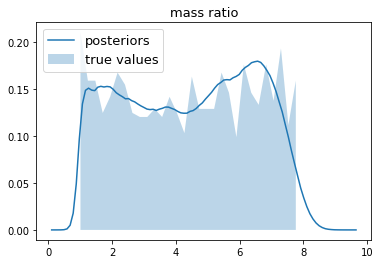

In [ ]:
names = ['mass','spin','mass ratio']
i = 2
ty, tx = np.histogram(testset.y[:,i],bins=30,density=True)
d = samples[:,i,:].flatten()
dy, dx = np.histogram(d,bins=100,density=True)
plt.plot(dx[:-1],dy,label='posteriors')
#plt.plot(tx[:-1],ty,label='true values')
plt.fill_between(tx[:-1],0,ty,label='true values',alpha=0.3)
plt.legend(loc='upper left',fontsize=13)
plt.title(names[i],fontsize=13)
plt.show()

Finally, we investigate the behaviour of the corner plots; we will fix SNR$=60$

In [10]:
!pip install corner
import corner

In [13]:
SNR = 60
testset.reset().add_noise(noise,SNR)
n_samples = int(1e4)
samples = model.sample(testset.x,n_samples)
#testset.reset();

ground truth:  [65.07648316  0.80222756  1.51471471]


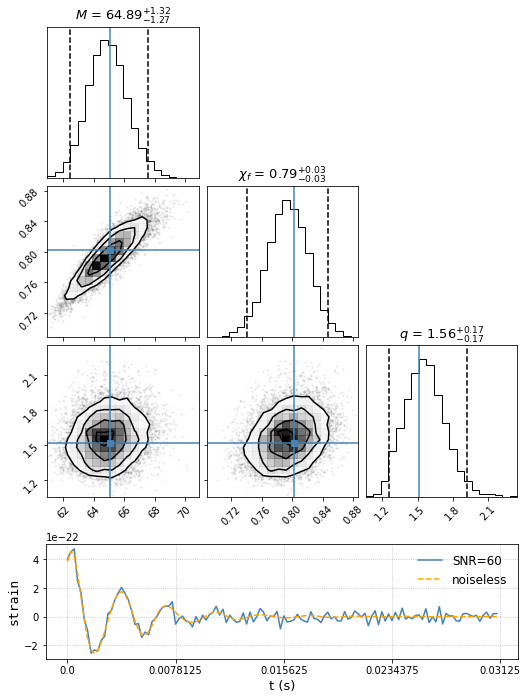

In [14]:
##  draw a contour plot
## https://corner.readthedocs.io/en/latest/api.html
idx = np.argsort(testset.y[:,0],axis=0)
N = 500
sample = samples[idx[N]]
p = 0.95
a = min((1-p)/2,(1+p)/2)
b = 1-a
print('ground truth: ',testset.y[idx[N]][:ny])
figure = corner.corner(sample.T,titles=['$M$','$\chi_f$','$q$'],\
                       labels = None,\
                       quantiles=[a,b],\
                       show_titles=True,title_kwargs={'fontsize':13},\
                       truths=testset.y[idx[N]],truth_color='steelblue')

figure.set_size_inches((8,8))
# plot the signal

left, bottom, width, height = [0.129, -0.15, 0.82, 0.2]
ax2 = figure.add_axes([left, bottom, width, height])
hfont = {'fontfamily':'monospace'}
ax2.plot(testset.x[idx[500]],label='SNR=%d'%60,color='steelblue')
ax2.set_facecolor('white')
A = 60/testset.snr[idx[500]]
ax2.plot(A*testset.x0[idx[500]],label='noiseless',color='orange',linestyle='--')
plt.legend(fontsize=12,frameon=False)
ax2.set_ylabel('strain',fontsize=13,**hfont)
ax2.set_xlabel('t (s)',fontsize=13)
ax2.set_xticks(np.linspace(0,128,5))
ax2.set_xticklabels(np.linspace(0,128/4096,5))
#ax2.set_tight_layout()
ax2.grid(linestyle=':',alpha=0.9)

#figure.tight_layout()
#figure.savefig(PROJECT_PATH+'/plots/contour.pdf',bbox_inches='tight');

# Test spin relation

In this section we want to show that the trained CVAE is able to recover the analytical relation between the spin and the mass ratio
$$
\chi_f = 2\sqrt{3}\eta-3.871\eta^2+4.028\eta^3+\mathcal{O}(\eta^4)
$$
where $\eta=q/(1+q)^2$ is the symmetric mass ratio. In our module, the above relation is expressed by the function `spin_fit`.

In [ ]:
rd = SourceFileLoader('rd',join(PROJECT_PATH,'Modules/Ringdown2.py')).load_module()
qnmmod = SourceFileLoader('qnmmod',join(PROJECT_PATH,'Modules/qnm_cvae.py')).load_module()
from rd import spin_fit
from qnmmod import GWDataset, Regressor_Bayes, CVAE

In [ ]:
## load the model
qnmmod.DEVICE = DEVICE
modelfile = PROJECT_PATH+'/cvae_models/foo_128_10.pkl'
checkpoint = torch.load(modelfile)
net = CVAE(**checkpoint['params']).to(DEVICE)
model = Regressor_Bayes(net)
model.load(modelfile,map_location=DEVICE)

In [ ]:
## load the data
DATA_FILE = join(PROJECT_PATH,'Data/qnm_3m_numerical.hdf5')
NOISE_FILE = PROJECT_PATH+'/Data/Noises.hdf5'

## prepare data
ny = 3
group='test2'
NBINS = 128
with h5py.File(DATA_FILE,'r') as f:
  X_test = f[group+'/data'][()][:,:NBINS]
  y_test = f[group+'/target'][()][:,:ny]
  z_test = f[group+'/snr'][()]
  labels = f[group+'/target'].attrs['labels'][:ny]
testset = GWDataset(X_test,y_test,z_test)

with h5py.File(NOISE_FILE,'r') as f:
  noise = f['ET/noise'][()][-len(testset):,:NBINS]

### Stacking multiple events

In order to test the spin relation, we implement an ordinary least squared (OLS) fit. In particular, we consider the relation
$$
\chi_f^{\rm meas}=a+b\chi_f^{\rm infer}
$$
where
- $\chi_f^{\rm meas}$ is the measured value of the spin, defined as the median of the spin posteriors;
- $\chi_f^{\rm infer}$ is the spin as obtained from the spin relation using the measured value of the mass ratio $q^{\rm meas}$.

In the ideal case, $a=0$ and $b=1$. In practice, we will measure the success of the test by the amount to which $a$ and $b$ are compatible with $0$ and $1$, resspectively. We will perform the test using the module `statsmodels`.

In [ ]:
## sample from the testset
SNR = np.random.uniform(40,80,len(testset))
testset.reset().add_noise(noise,SNR)
n_samples = int(1e4)
samples = model.sample(testset.x,n_samples)
testset.reset();

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def fit_results(samples,nobs):
  idx = np.random.choice(len(samples),nobs,replace=False)
  y = np.median(samples[idx,1],axis=-1)
  x = np.median(spin_fit(samples[idx,2]),axis=-1)
  X = np.vstack((x,np.ones(len(x))))
  mod = sm.OLS(y,X.T)
  res = mod.fit()
  df = pd.read_html(res.summary().tables[1].as_html(),header=0,index_col=0)[0]
  return df

def benchmark_fit(samples,nobs):
  mu = np.zeros((2,len(nobs)))
  scale = np.zeros((2,len(nobs)))
  nr = 10
  for i in range(len(nobs)):
    for j in range(nr):
      df = fit_results(samples,nobs[i])
      mu[:,i] += np.array(df['coef'])/nr
      scale[:,i] += np.array(df['std err'])/nr
  return mu, scale

In [ ]:
fit_results(samples,len(samples))

,coef,std err,t,P>|t|,[0.025,0.975]
x1,0.9837,0.018,54.810,0.00,0.948,1.019
const,-0.0018,0.009,-0.201,0.84,-0.019,0.015


In [ ]:
nobs = np.array([20,50,70,100,200,400,600,800,1000])
mu, scale = benchmark_fit(samples,nobs)

In [ ]:
mm = mu-2*scale
mp = mu+2*scale

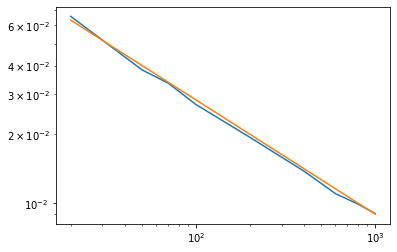

In [ ]:
## intercept
#plt.plot(nobs,scale0)
plt.plot(nobs,scale[1])
plt.plot(nobs,0.2*np.sqrt(2/nobs))
plt.xscale('log')
plt.yscale('log')

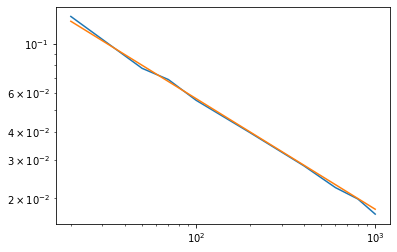

In [ ]:
## intercept
plt.plot(nobs,scale[0])
plt.plot(nobs,0.4*np.sqrt(2/nobs))
plt.xscale('log')
plt.yscale('log')

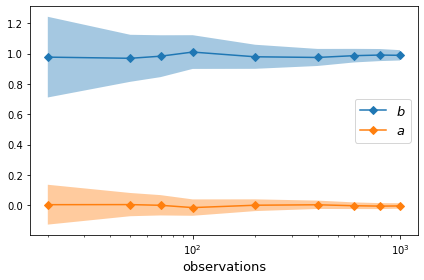

In [ ]:
plt.plot(nobs,mu[0],'-D',label='$b$')
plt.plot(nobs,mu[1],'-D',label='$a$')
plt.fill_between(nobs,mm[0],mp[0],alpha=0.4)
plt.fill_between(nobs,mm[1],mp[1],alpha=0.4)
plt.xscale('log')
plt.xlabel('observations',fontsize=13)
plt.legend(fontsize=13,loc='center right')
plt.tight_layout()
#plt.savefig(PROJECT_PATH+'/plots/ols_fit.pdf',bbox_inches='tight')

It is useful to display a scatter plot of $\chi_f^{\rm meas}$ versus $\chi_f^{\rm infer}$.

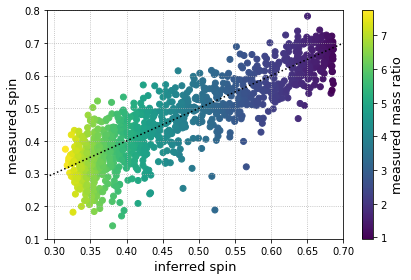

In [ ]:
y = np.median(samples[:,1],axis=-1) # measured
x = np.median(spin_fit(samples[:,2]),axis=-1) # inferred
cm = plt.cm.get_cmap('RdYlBu')
q = np.median(samples[:,2],axis=-1)
eta = q
sc = plt.scatter(x,y,c=eta)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('measured mass ratio', rotation=90, size=13)
plt.xlabel('inferred spin',fontsize=13)
plt.ylabel('measured spin',fontsize=13)
plt.xlim([0.29,0.7])
plt.ylim([0.1,0.8])
diag = np.linspace(0.1,0.8,100)
plt.plot(diag,diag,':',color='black')
plt.tight_layout()
plt.grid(linestyle=':',alpha=1)
#plt.savefig(PROJECT_PATH+'/plots/scatter_spins.pdf',bbox_inches='tight')

### Single events

Here we show how to produce a scatter plot to assess the constistence of a single event with the GR null hypothesis.


In [ ]:
!pip install corner
import corner

In [ ]:
## sample from the testset
SNR = 60
testset.reset().add_noise(noise,SNR)
n_samples = int(1e4)
samples = model.sample(testset.x,n_samples)
testset.reset();

In [ ]:
spin_meas = samples[:,1]
spin_infer = spin_fit(samples[:,2])

ground truth:  [52.64628227  0.66164235  1.53290174]


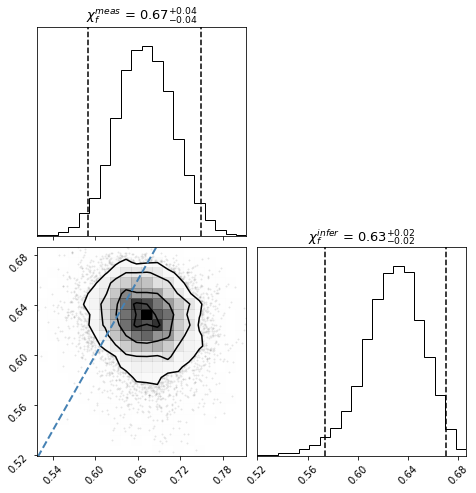

In [ ]:
idx = np.argsort(testset.y[:,1],axis=0)
N = 920
p = 0.95
a = min((1-p)/2,(1+p)/2)
b = 1-a
X = np.vstack((spin_meas[idx[N]],spin_infer[idx[N]]))
print('ground truth: ',testset.y[idx[N]][:ny])
figure = corner.corner(X.T,titles=['$\chi^{meas}_f$','$\chi^{infer}_f$'],\
                       labels = None,\
                       quantiles=[a,b],\
                       show_titles=True,title_kwargs={'fontsize':13},\
                       #truths=[testset.y[idx[N]][1]]*2,truth_color='green',\
                       )
axes = np.array(figure.axes).reshape((2,2))
ax = axes[1,0]
#diag = np.linspace(min(spin_meas.min(),spin_infer.min()),\
#                   max(spin_meas.max(),spin_infer.max()),100)
diag = np.linspace(0,0.9,100)
ax.plot(diag,diag,'--',color='steelblue',linewidth=2)

figure.set_size_inches((8,8))
#figure.tight_layout()
#figure.savefig(PROJECT_PATH+'/plots/identity_contour.pdf',bbox_inches='tight');